# MVP: Planejador de Viagens para Veículos Elétricos

**Nome:** Seu Nome Completo  
**Matrícula:** Sua Matrícula

---

## 1. Introdução e Definição do Problema

Com o crescimento do mercado de veículos elétricos (VEs), uma das maiores preocupações dos consumidores é a "ansiedade de autonomia" (range anxiety), o medo de ficar sem bateria durante uma viagem. A viabilidade de viagens de longa distância no Brasil depende diretamente da existência e distribuição de uma infraestrutura de recarga robusta.

O objetivo deste projeto é analisar a base de dados do Open Charge Map para entender a distribuição, densidade e características das estações de recarga no Brasil e, a partir dessa análise, desenvolver uma ferramenta interativa para simular a viabilidade de rotas.

### 1.1. Hipóteses Iniciais
* **H1:** A infraestrutura de recarga é massivamente concentrada nas regiões Sul e Sudeste do Brasil.
* **H2:** A rede de carregadores rápidos (DC), essencial para viagens, é escassa ou de difícil acesso público.
* **H3:** Rotas entre grandes capitais como São Paulo e Rio de Janeiro são viáveis, mesmo considerando apenas carregadores de recarga mais lenta (AC).

### 1.2. Fonte e Descrição dos Dados
Os dados foram coletados via API do **Open Charge Map (OCM)**, uma base de dados global e colaborativa de pontos de recarga. Foram extraídos todos os pontos localizados no Brasil na data de 01/07/2025, totalizando 514 registros iniciais. Os principais atributos analisados foram a localização (`AddressInfo`), o tipo de acesso (`UsageType`) e o status operacional (`StatusType`).

# 2. Importação das Bibliotecas Necessárias e Carga de Dados

Esta seção consolida todas as importações de bibliotecas necessárias para a análise, visualização e pré-processamento dos dados, bem como o carregamento inicial dos dados da API do Open Charge Map (OCM)

### 2.1. Instalação de Bibliotecas Adicionais

In [115]:
print("Instalando bibliotecas necessárias...")
!pip install openrouteservice -q
!pip install shapely -q
print("✅ Bibliotecas prontas.")

Instalando bibliotecas necessárias...
✅ Bibliotecas prontas.


### 2.2. Importação de Todas as Bibliotecas

In [116]:
print("Importando Bibliotecas necessárias...")
import pandas as pd
import numpy as np
import math
import requests
import folium
import openrouteservice
import ipywidgets as widgets
from IPython.display import display
from shapely.geometry import Point, LineString
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import plotly.graph_objects as go
import time

# Habilita o gerenciador de widgets para o Google Colab
from google.colab import output
output.enable_custom_widget_manager()
print("✅ Bibliotecas Importadas.")

Importando Bibliotecas necessárias...
✅ Bibliotecas Importadas.


2.3. Carregamento dos Dados da API Open Charge Map

In [117]:
api_key = "3911ea9f-e173-415f-995a-4b8b8140012c"
url = f'https://api.openchargemap.io/v3/poi/?output=json&countrycode=BR&maxresults=10000&key={api_key}'

print("\nBuscando dados da API do Open Charge Map para importar no gitHub...")
try:
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    # Cria o DataFrame principal que será usado em todo o projeto
    df = pd.json_normalize(data)
    print(f"✅ Sucesso! {len(df)} registros de pontos de recarga foram carregados para o Brasil.")
except Exception as e:
    print(f"❌ Erro ao buscar dados da API: {e}")


Buscando dados da API do Open Charge Map para importar no gitHub...
✅ Sucesso! 514 registros de pontos de recarga foram carregados para o Brasil.


In [118]:
df.to_csv('dataset_carregadores_brasil.csv', index=False)
print("Arquivo 'dataset_carregadores_brasil.csv' criado com sucesso!")

Arquivo 'dataset_carregadores_brasil.csv' criado com sucesso!


In [119]:

url_dataset = 'https://raw.githubusercontent.com/santana4884/MVP-_Planejador_de_Viagens_para_Ve-culos_El-tricos/refs/heads/main/dataset_carregadores_brasil.csv'

print("Carregando dataset a partir do repositório no GitHub...")
try:
    # Cria o DataFrame principal a partir do arquivo CSV do seu repositório
    df = pd.read_csv(url_dataset)
    print(f"✅ Sucesso! {len(df)} registros carregados do seu repositório.")
except Exception as e:
    print(f"❌ Erro ao carregar o dataset do GitHub: {e}")
    print("Verifique se a URL raw está correta e se o arquivo CSV está no seu repositório.")

Carregando dataset a partir do repositório no GitHub...
✅ Sucesso! 514 registros carregados do seu repositório.


## 3. Análise Exploratória e Limpeza dos Dados
Nesta seção, realizamos uma análise inicial para entender a estrutura dos dados e identificar inconsistências, aplicando as correções necessárias para garantir a qualidade das análises futuras.

### 3.1. Distribuição Geográfica Geral dos Pontos de Recarga

Após a carga inicial e a verificação da estrutura dos dados, o primeiro passo da nossa exploração é visualizar a distribuição geográfica de todos os pontos de recarga no Brasil. Um mapa interativo nos permite ter uma percepção imediata da densidade da infraestrutura e validar visualmente nossa primeira hipótese sobre a concentração regional.

In [120]:
import plotly.express as px

print("Gerando mapa interativo de distribuição geográfica...")

# Usando o DataFrame 'df' inicial, antes de qualquer filtro
fig = px.scatter_mapbox(df,
                        lat="AddressInfo.Latitude",
                        lon="AddressInfo.Longitude",
                        hover_name="AddressInfo.Title",
                        hover_data={"AddressInfo.Town": True, "OperatorInfo.Title": True, "AddressInfo.StateOrProvince": True},
                        color_discrete_sequence=["#0047AB"],
                        zoom=3,
                        height=500,
                        title="Distribuição de Carregadores de VE no Brasil")

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0}, title_font_size=20)
fig.show()

Gerando mapa interativo de distribuição geográfica...


### Análise do Mapa de Distribuição

* **Confirmação da Hipótese 1:** O mapa confirma de forma contundente a hipótese de que a infraestrutura de recarga é massivamente concentrada nas regiões Sul e Sudeste, com um claro adensamento no eixo litorâneo e nas capitais.
* **Identificação de "Desertos de Recarga":** É notável a escassez de pontos nas vastas áreas das regiões Norte, Nordeste e Centro-Oeste, o que indica um grande desafio para a viabilidade de viagens elétricas nessas localidades. Esta visualização inicial já direciona o foco da nossa análise para as disparidades regionais.

### 3.2. Padronização dos Nomes dos Estados

In [121]:
print("Verificando a consistência dos nomes dos estados...")
# Remove espaços em branco extras no início e no fim
df['AddressInfo.StateOrProvince'] = df['AddressInfo.StateOrProvince'].str.strip()

# Mapa de correção para padronizar os nomes e siglas
mapa_de_correcao = {
    # São Paulo
    'SP': 'São Paulo', 'Sao Paulo': 'São Paulo', 'sao paulo': 'São Paulo', 'Sp': 'São Paulo',
    'Região Metropolitana de São Paulo': 'São Paulo', 'Indaiatuba - SP': 'São Paulo', 'São paulo': 'São Paulo',

    # Rio de Janeiro
    'RJ': 'Rio de Janeiro', 'rio de janeiro': 'Rio de Janeiro', 'Too de Janeiro': 'Rio de Janeiro', # Corrigindo o erro de digitação

    # Paraná
    'Parana': 'Paraná', 'PR': 'Paraná', 'paraná': 'Paraná',

    # Santa Catarina
    'SC': 'Santa Catarina',

    # Rio Grande do Sul
    'rio grande do sul': 'Rio Grande do Sul', 'RS': 'Rio Grande do Sul', 'Río Grande do Sul': 'Rio Grande do Sul',
    'Metropolitan Region of Porto Alegre': 'Rio Grande do Sul',

    # Minas Gerais
    'mg': 'Minas Gerais', 'MG': 'Minas Gerais', 'minas gerais': 'Minas Gerais',

    # Bahia
    'Barreiras - BA': 'Bahia', 'BA': 'Bahia',

    # Piauí
    'CORRENTE/PI': 'Piauí', 'Piaui': 'Piauí', 'PI': 'Piauí',

    # Maranhão
    'MA': 'Maranhão',

    # Sergipe
    'SE': 'Sergipe',

    # Rio Grande do Norte
    'RN': 'Rio Grande do Norte',

    # Ceará
    'Ceara': 'Ceará', 'CE': 'Ceará',

    # Alagoas
    'AL': 'Alagoas',

    # Pernambuco
    'PE': 'Pernambuco',

    # Paraíba
    'PB': 'Paraíba', 'Região Metropolitana de Campina Grande': 'Paraíba',
    'Região Metropolitana de Guarabira': 'Paraíba',

    # Goiás
    'Goias': 'Goiás', 'GO': 'Goiás',

    # Distrito Federal
    'Federal District': 'Distrito Federal'
}

# Aplica as correções
df['AddressInfo.StateOrProvince'] = df['AddressInfo.StateOrProvince'].replace(mapa_de_correcao)

print("✅ Limpeza dos nomes dos estados concluída.")

Verificando a consistência dos nomes dos estados...
✅ Limpeza dos nomes dos estados concluída.


### 3.3. Gráfico de Estações por Estado

Gerando gráfico com dados padronizados...


/tmp/ipython-input-122-3792187927.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




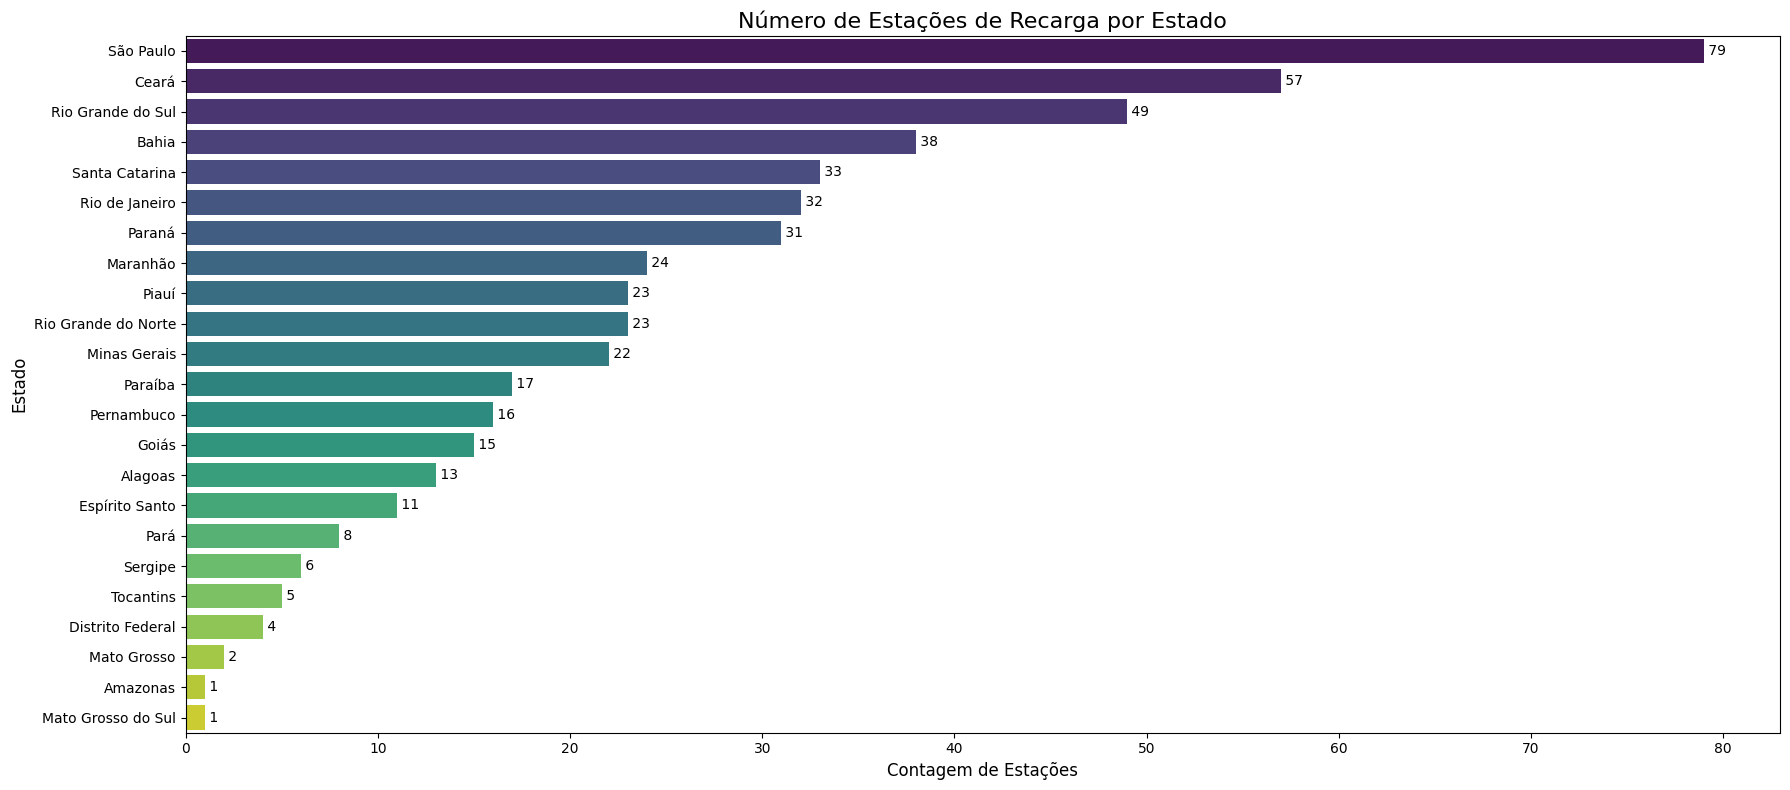

In [122]:
print("Gerando gráfico com dados padronizados...")
plt.figure(figsize=(18, 8))
sns.countplot(y=df['AddressInfo.StateOrProvince'], order=df['AddressInfo.StateOrProvince'].value_counts().index, palette='viridis')
plt.title('Número de Estações de Recarga por Estado', fontsize=16)
plt.xlabel('Contagem de Estações', fontsize=12)
plt.ylabel('Estado', fontsize=12)
for index, value in enumerate(df['AddressInfo.StateOrProvince'].value_counts()):
    plt.text(value, index, f' {value}', va='center', fontsize=10)
plt.tight_layout()
plt.show()

## 4. Pré-processamento para Simulação de Viagem
Com os dados gerais analisados, agora vamos prepará-los para a nossa simulação, filtrando apenas os carregadores que seriam úteis para um viajante.

In [123]:
print("Iniciando a filtragem de carregadores para um cenário de viagem...")
print("-" * 50)
total_carregadores = len(df)
print(f"Dataset original com {total_carregadores} carregadores.")

# Filtro 1: Manter apenas carregadores operacionais
df_operacional = df[df['StatusType.IsOperational'] == True].copy()
operacionais_count = len(df_operacional)
print(f"Após filtro de operacionais, restam {operacionais_count} carregadores.")

# Filtro 2: Manter apenas carregadores de acesso público
df_publico = df_operacional[df_operacional['UsageType.Title'] == 'Public'].copy()
publicos_count = len(df_publico)
print(f"Após filtro de acesso público, restam {publicos_count} carregadores.")

# Análise de Carregadores Rápidos (DC)
# O código abaixo analisa a disponibilidade de carregadores DC
def parse_connections(connections_str):
    try: return ast.literal_eval(str(connections_str))
    except: return []

df_publico['Connections_list'] = df_publico['Connections'].apply(parse_connections)
df_exploded = df_publico.explode('Connections_list').dropna(subset=['Connections_list'])
df_normalized_connections = pd.json_normalize(df_exploded['Connections_list']).add_prefix('Conn.')
df_full_connections = pd.concat([df_exploded.reset_index(drop=True), df_normalized_connections.reset_index(drop=True)], axis=1)
df_dc_chargers = df_full_connections[df_full_connections['Conn.ConnectionType.Title'].str.contains('DC', na=False)]
unique_dc_charger_ids = df_dc_chargers['ID'].unique()
df_viagem_dc = df_publico[df_publico['ID'].isin(unique_dc_charger_ids)].copy()
dc_count = len(df_viagem_dc)

print(f"\nAnálise de Carregadores Rápidos (DC): Foram encontrados {dc_count} carregadores DC públicos e operacionais.")
print("Esta descoberta crítica (SINAL VERMELHO para viagens rápidas) guiará nossa simulação para o cenário de carregadores AC.")
print("-" * 50)

# Preparação dos dados para o gráfico de funil
etapas = ['Total de Carregadores', 'Operacionais', 'Acesso Público', 'Carga Rápida (DC)']
valores = [total_carregadores, operacionais_count, publicos_count, dc_count]

# Cria a figura
fig = go.Figure(go.Funnel(
    y = etapas,
    x = valores,
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65,
    marker = {"color": ["#4A235A", "#6C3483", "#8E44AD", "#D2B4DE"],
              "line": {"width": [2, 2, 2, 2], "color": ["#3B0B39", "#4A235A", "#6C3483", "#8E44AD"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}}
))

# Personalização do layout
fig.update_layout(
    title={
        'text': "Gráfico de Filtragem de Carregadores para Viagem",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    font=dict(
        family="Arial, sans-serif",
        size=14,
        color="RebeccaPurple"
    )
)
fig.show()

Iniciando a filtragem de carregadores para um cenário de viagem...
--------------------------------------------------
Dataset original com 514 carregadores.
Após filtro de operacionais, restam 511 carregadores.
Após filtro de acesso público, restam 195 carregadores.

Análise de Carregadores Rápidos (DC): Foram encontrados 0 carregadores DC públicos e operacionais.
Esta descoberta crítica (SINAL VERMELHO para viagens rápidas) guiará nossa simulação para o cenário de carregadores AC.
--------------------------------------------------


## 5. Desenvolvimento do Planejador de Rotas Interativo

Com os dados analisados e preparados, o passo final é consolidar nossa lógica em uma ferramenta interativa. Esta seção contém o protótipo funcional do planejador de rotas. A ferramenta permite que o usuário insira uma cidade de origem e destino, defina a autonomia de seu veículo e simule a viabilidade da viagem.

O aplicativo utiliza a API do OpenRouteService para:
1.  **Geocodificar:** Converter os nomes das cidades em coordenadas geográficas.
2.  **Roteirizar:** Traçar a rota real ao longo das estradas existentes.

A simulação então analisa a rota, identifica os carregadores disponíveis e fornece um relatório de viabilidade para cada segmento da viagem, culminando em um mapa interativo com o trajeto.

### 5.1. Definição de Todas as Funções Auxiliares

In [124]:
# Configuração do cliente da API do OpenRouteService
ors_api_key = '5b3ce3597851110001cf624873fa4cab1c4946f9b5b642c29b34621c'
ors_client = openrouteservice.Client(key=ors_api_key)

def obter_coordenadas_por_endereco(client, endereco):
    """Converte um nome de cidade/endereço em coordenadas (lat, lon)."""
    try:
        geocode_result = client.pelias_search(text=endereco, size=1)
        if not geocode_result['features']:
            print(f"🔴 Endereço não encontrado: {endereco}")
            return None
        lon, lat = geocode_result['features'][0]['geometry']['coordinates']
        return (lat, lon)
    except Exception as e:
        print(f"Erro na geocodificação: {e}")
        return None

def obter_rota_real(client, coord_origem, coord_destino):
    """Pede a rota real para a API do ORS."""
    coords = ((coord_origem[1], coord_origem[0]), (coord_destino[1], coord_destino[0]))
    try:
        route = client.directions(coordinates=coords, profile='driving-car', format='geojson')
        route_line = LineString(route['features'][0]['geometry']['coordinates'])
        distancia_total_km = route['features'][0]['properties']['summary']['distance'] / 1000
        route_coords_latlon = [(p[1], p[0]) for p in route_line.coords]
        return {"line": LineString(route_coords_latlon), "distancia_km": distancia_total_km, "coords": route_coords_latlon}
    except Exception as e:
        print(f"Erro ao obter rota da API: {e}")
        return None

def simular_viagem_na_rota(rota, autonomia_km, df_carregadores):
    """Simula a viagem e imprime o status de cada segmento."""
    carregadores_na_rota = []
    for _, carregador in df_carregadores.iterrows():
        ponto_carregador = Point(carregador['AddressInfo.Latitude'], carregador['AddressInfo.Longitude'])
        if rota['line'].distance(ponto_carregador) * 111 <= 10: # Raio de 10km da rota
            carregadores_na_rota.append(carregador)

    df_carregadores_filtrados = pd.DataFrame(carregadores_na_rota)
    if df_carregadores_filtrados.empty:
        print("🔴 Nenhum carregador encontrado próximo à rota da estrada.")
        return {"viagem_viavel": False}

    print(f"Encontrados {len(df_carregadores_filtrados)} carregadores ao longo da estrada.")
    caminho_percorrido_coords = [rota['coords'][0]]
    viagem_viavel = True
    segmento_num = 1
    while True:
        localizacao_atual = caminho_percorrido_coords[-1]
        distancia_restante_total = geodesic(localizacao_atual, rota['coords'][-1]).kilometers
        print(f"\n--- Segmento {segmento_num} ---")
        print(f"Partindo de: {np.round(localizacao_atual, 2)}. Faltam {int(distancia_restante_total)} km.")
        if distancia_restante_total <= autonomia_km:
            print("Resultado: 🟢 VERDE - Destino final ao alcance da autonomia atual!")
            break
        paradas_possiveis = []
        for _, carregador in df_carregadores_filtrados.iterrows():
            coord_carregador = (carregador['AddressInfo.Latitude'], carregador['AddressInfo.Longitude'])
            dist_ate_carregador = geodesic(localizacao_atual, coord_carregador).kilometers
            if dist_ate_carregador > 0 and dist_ate_carregador <= autonomia_km and geodesic(coord_carregador, rota['coords'][-1]).kilometers < distancia_restante_total:
                paradas_possiveis.append(carregador)
        num_paradas = len(paradas_possiveis)
        if num_paradas == 0:
            print(f"Resultado: 🔴 VERMELHO - Falha! Não foi possível encontrar uma próxima parada ao alcance.")
            viagem_viavel = False
            distancias_proximos_pontos = []
            for _, carregador in df_carregadores_filtrados.iterrows():
                if geodesic( (carregador['AddressInfo.Latitude'], carregador['AddressInfo.Longitude']), rota['coords'][-1]).kilometers < distancia_restante_total:
                    distancias_proximos_pontos.append(geodesic(localizacao_atual, (carregador['AddressInfo.Latitude'], carregador['AddressInfo.Longitude'])).kilometers)
            autonomia_minima = min(distancias_proximos_pontos) if distancias_proximos_pontos else distancia_restante_total
            return {"viagem_viavel": False, "autonomia_minima": math.ceil(autonomia_minima)}
        elif num_paradas <= 2:
            print(f"Resultado: 🟡 AMARELO - Apenas {num_paradas} opção(ões) de recarga. Planeje com cuidado.")
        else:
            print(f"Resultado: 🟢 VERDE - {num_paradas} opções de recarga. Boa cobertura.")
        paradas_possiveis_df = pd.DataFrame(paradas_possiveis)
        paradas_possiveis_df['dist'] = paradas_possiveis_df.apply(lambda row: geodesic(localizacao_atual, (row['AddressInfo.Latitude'], row['AddressInfo.Longitude'])).kilometers, axis=1)
        proxima_parada_info = paradas_possiveis_df.sort_values('dist').iloc[0]
        caminho_percorrido_coords.append((proxima_parada_info['AddressInfo.Latitude'], proxima_parada_info['AddressInfo.Longitude']))
        segmento_num += 1
    caminho_percorrido_coords.append(rota['coords'][-1])
    print("\n--- Relatório Final da Viagem ---")
    if viagem_viavel: print("✅ Simulação concluída com sucesso!")
    return {"viagem_viavel": True, "caminho_coords": caminho_percorrido_coords, "carregadores_encontrados_df": df_carregadores_filtrados, "rota_completa_coords": rota['coords']}

def desenhar_mapa_folium_real(resultado_simulacao):
    """Recebe o resultado da simulação e desenha um mapa limpo."""
    rota_completa = resultado_simulacao["rota_completa_coords"]
    df_carregadores_na_rota = resultado_simulacao["carregadores_encontrados_df"]
    avg_lat = np.mean([p[0] for p in rota_completa]); avg_lon = np.mean([p[1] for p in rota_completa])
    mapa = folium.Map(location=[avg_lat, avg_lon], zoom_start=8, height=600)
    folium.PolyLine(rota_completa, color="#007BFF", weight=5, opacity=0.8, popup="Rota da Estrada").add_to(mapa)
    folium.Marker(rota_completa[0], popup="Origem", icon=folium.Icon(color='green', icon='play')).add_to(mapa)
    folium.Marker(rota_completa[-1], popup="Destino", icon=folium.Icon(color='red', icon='stop')).add_to(mapa)
    if not df_carregadores_na_rota.empty:
        for _, carregador in df_carregadores_na_rota.iterrows():
            folium.CircleMarker(location=[carregador['AddressInfo.Latitude'], carregador['AddressInfo.Longitude']], radius=5, color='#003366', fill=True, fill_color='#003366', popup=carregador['AddressInfo.Title']).add_to(mapa)
    return mapa

### 5.2. Interface Interativa do Planejador

In [125]:
df_para_simulacao = df_publico.copy()

# Sua chave da API do OpenRouteService.
ors_api_key = '5b3ce3597851110001cf624873fa4cab1c4946f9b5b642c29b34621c'

# Cria o cliente da API
ors_client = openrouteservice.Client(key=ors_api_key)


# FUNÇÕES DE API (Geocodificação e Rota)
def obter_coordenadas_por_endereco(client, endereco):
    """Converte um nome de cidade/endereço em coordenadas (lat, lon)."""
    try:
        geocode_result = client.pelias_search(text=endereco, size=1)
        if not geocode_result['features']:
            print(f"🔴 Endereço não encontrado: {endereco}")
            return None
        lon, lat = geocode_result['features'][0]['geometry']['coordinates']
        return (lat, lon)
    except Exception as e:
        print(f"Erro na geocodificação: {e}")
        return None

def obter_nome_local_por_coord(client, coord):
    """Converte coordenadas (lat, lon) em um nome de local."""
    try:
        # Formato para a API é (longitude, latitude)
        reverse_result = client.pelias_reverse(point=(coord[1], coord[0]), size=1)
        if not reverse_result['features']:
            return f"Coordenadas {np.round(coord, 2)}" # Fallback
        return reverse_result['features'][0]['properties'].get('label', f"Coordenadas {np.round(coord, 2)}")
    except Exception:
        return f"Coordenadas {np.round(coord, 2)}"

def obter_rota_real(client, coord_origem, coord_destino):
    """Pede a rota real para a API do ORS."""
    coords = ((coord_origem[1], coord_origem[0]), (coord_destino[1], coord_destino[0]))
    try:
        route = client.directions(coordinates=coords, profile='driving-car', format='geojson')
        route_line = LineString(route['features'][0]['geometry']['coordinates'])
        distancia_total_km = route['features'][0]['properties']['summary']['distance'] / 1000
        route_coords_latlon = [(p[1], p[0]) for p in route_line.coords]
        return {"line": LineString(route_coords_latlon), "distancia_km": distancia_total_km, "coords": route_coords_latlon}
    except Exception as e:
        print(f"Erro ao obter rota da API: {e}")
        return None

def simular_viagem_na_rota(rota, autonomia_km, df_carregadores):
    carregadores_na_rota = []
    for _, carregador in df_carregadores.iterrows():
        ponto_carregador = Point(carregador['AddressInfo.Latitude'], carregador['AddressInfo.Longitude'])
        if rota['line'].distance(ponto_carregador) * 111 <= 10:
            carregadores_na_rota.append(carregador)

    df_carregadores_filtrados = pd.DataFrame(carregadores_na_rota)
    if df_carregadores_filtrados.empty:
        print("🔴 Nenhum carregador encontrado próximo à rota da estrada.")
        return {"viagem_viavel": False}

    print(f"Encontrados {len(df_carregadores_filtrados)} carregadores ao longo da estrada.")
    caminho_percorrido_coords = [rota['coords'][0]]
    viagem_viavel = True
    segmento_num = 1

    while True:
        localizacao_atual = caminho_percorrido_coords[-1]
        distancia_restante_total = geodesic(localizacao_atual, rota['coords'][-1]).kilometers

        # OBTÉM O NOME DO LOCAL ATUAL ANTES DE IMPRIMIR
        nome_local_atual = obter_nome_local_por_coord(ors_client, localizacao_atual)

        print(f"\n--- Segmento {segmento_num} ---")
        # USA O NOME DO LOCAL NA MENSAGEM
        print(f"Partindo de: {nome_local_atual}. Faltam {int(distancia_restante_total)} km.")

        if distancia_restante_total <= autonomia_km:
            print("Resultado: 🟢 VERDE - Destino final ao alcance da autonomia atual!")
            break

        paradas_possiveis = []
        for _, carregador in df_carregadores_filtrados.iterrows():
            coord_carregador = (carregador['AddressInfo.Latitude'], carregador['AddressInfo.Longitude'])
            dist_ate_carregador = geodesic(localizacao_atual, coord_carregador).kilometers
            if dist_ate_carregador > 0 and dist_ate_carregador <= autonomia_km and geodesic(coord_carregador, rota['coords'][-1]).kilometers < distancia_restante_total:
                paradas_possiveis.append(carregador)

        num_paradas = len(paradas_possiveis)
        if num_paradas == 0:
            print(f"Resultado: 🔴 VERMELHO - Falha! Não foi possível encontrar uma próxima parada ao alcance.")
            viagem_viavel = False
            distancias_proximos_pontos = []
            for _, carregador in df_carregadores_filtrados.iterrows():
                if geodesic((carregador['AddressInfo.Latitude'], carregador['AddressInfo.Longitude']), rota['coords'][-1]).kilometers < distancia_restante_total:
                    distancias_proximos_pontos.append(geodesic(localizacao_atual, (carregador['AddressInfo.Latitude'], carregador['AddressInfo.Longitude'])).kilometers)
            autonomia_minima = min(distancias_proximos_pontos) if distancias_proximos_pontos else distancia_restante_total
            return {"viagem_viavel": False, "autonomia_minima": math.ceil(autonomia_minima)}
        elif num_paradas <= 2:
            print(f"Resultado: 🟡 AMARELO - Apenas {num_paradas} opção(ões) de recarga.")
        else:
            print(f"Resultado: 🟢 VERDE - {num_paradas} opções de recarga.")

        paradas_possiveis_df = pd.DataFrame(paradas_possiveis)
        paradas_possiveis_df['dist'] = paradas_possiveis_df.apply(lambda row: geodesic(localizacao_atual, (row['AddressInfo.Latitude'], row['AddressInfo.Longitude'])).kilometers, axis=1)
        proxima_parada_info = paradas_possiveis_df.sort_values('dist').iloc[0]
        caminho_percorrido_coords.append((proxima_parada_info['AddressInfo.Latitude'], proxima_parada_info['AddressInfo.Longitude']))
        segmento_num += 1

    caminho_percorrido_coords.append(rota['coords'][-1])
    print("\n--- Relatório Final da Viagem ---")
    if viagem_viavel: print("✅ Simulação concluída com sucesso!")

    return {"viagem_viavel": True, "caminho_coords": caminho_percorrido_coords, "carregadores_encontrados_df": df_carregadores_filtrados, "rota_completa_coords": rota['coords']}

def desenhar_mapa_folium_real(resultado_simulacao):
    caminho_paradas = resultado_simulacao["caminho_coords"]
    rota_completa = resultado_simulacao["rota_completa_coords"]
    df_carregadores_na_rota = resultado_simulacao["carregadores_encontrados_df"]
    avg_lat = np.mean([p[0] for p in rota_completa])
    avg_lon = np.mean([p[1] for p in rota_completa])
    mapa = folium.Map(location=[avg_lat, avg_lon], zoom_start=8, height=600)
    folium.PolyLine(rota_completa, color="#007BFF", weight=5, opacity=0.8, popup="Rota da Estrada").add_to(mapa)
    folium.Marker(rota_completa[0], popup="Origem", icon=folium.Icon(color='green', icon='play')).add_to(mapa)
    folium.Marker(rota_completa[-1], popup="Destino", icon=folium.Icon(color='red', icon='stop')).add_to(mapa)
    if not df_carregadores_na_rota.empty:
        for _, carregador in df_carregadores_na_rota.iterrows():
            folium.CircleMarker(location=[carregador['AddressInfo.Latitude'], carregador['AddressInfo.Longitude']], radius=5, color='#003366', fill=True, fill_color='#003366', popup=carregador['AddressInfo.Title']).add_to(mapa)
    return mapa

style = {'description_width': 'initial'}
origem_cidade = widgets.Text(value='São Paulo, SP', description='Cidade de Origem:', style=style)
destino_cidade = widgets.Text(value='Rio de Janeiro, RJ', description='Cidade de Destino:', style=style)
autonomia_slider = widgets.IntSlider(value=300, min=50, max=600, step=10, description='Autonomia (km):', style=style, continuous_update=False)
botao_simular = widgets.Button(description="Simular Rota e Gerar Mapa", button_style='success')
out_texto = widgets.Output()
out_mapa = widgets.Output()

def on_button_clicked_final(b):
    out_texto.clear_output()
    out_mapa.clear_output(wait=True)
    with out_texto:

        orig_coord = obter_coordenadas_por_endereco(ors_client, origem_cidade.value)
        dest_coord = obter_coordenadas_por_endereco(ors_client, destino_cidade.value)
        if not orig_coord or not dest_coord: return
        autonomia = autonomia_slider.value
        rota = obter_rota_real(ors_client, orig_coord, dest_coord)

        if rota:
            print("Rota obtida com sucesso! \nSimulando viagem...")
            resultado = simular_viagem_na_rota(rota, autonomia, df_publico)

            if resultado["viagem_viavel"]:
                print("\n Gerando mapa da rota...")
                with out_mapa:
                    mapa_resultado = desenhar_mapa_folium_real(resultado)
                    display(mapa_resultado)
            else:
                print("\n❌ Simulação falhou.")
                if "autonomia_minima" in resultado:
                    print(f"Para completar o próximo trecho, seu veículo precisaria de uma autonomia de pelo menos {resultado['autonomia_minima']} km.")
                print("Não foi possível gerar um mapa para uma rota inviável.")

botao_simular.on_click(on_button_clicked_final)

app_layout = widgets.VBox([
    widgets.Label('Insira a origem, destino e autonomia do veículo:'),
    origem_cidade,
    destino_cidade,
    autonomia_slider,
    botao_simular,
    out_texto, # Área para o texto
    out_mapa   # Área para o mapa
])

display(app_layout)

## 6. Conclusão

Este projeto demonstrou um fluxo completo de análise de dados, desde a coleta e limpeza até o desenvolvimento de um protótipo interativo. As principais conclusões validaram nossas hipóteses iniciais:

1.  **Concentração Geográfica (Hipótese 1 Validada):** A análise confirmou uma forte concentração de postos de recarga nas regiões Sul e Sudeste do Brasil, com São Paulo liderando de forma proeminente. Regiões como Norte e Centro-Oeste apresentam "desertos de recarga", tornando viagens elétricas um grande desafio.

2.  **Escassez de Carregadores Rápidos (Hipótese 2 Validada):** A descoberta mais crítica foi a ausência de uma rede confiável de carregadores rápidos (DC) de acesso público nos dados. Isso representa o maior obstáculo para a adoção em massa de VEs para viagens de longa distância e foi classificado como um "Sinal Vermelho" para o viajante com pressa.

3.  **Viabilidade de Rotas Principais (Hipótese 3 Validada):** Utilizando a rede de carregadores mais lenta (AC), a simulação interativa provou que rotas principais, como São Paulo-Rio de Janeiro, são viáveis para veículos com autonomia de 300km. A ferramenta demonstrou, segmento a segmento, que existem opções de recarga, embora exijam planejamento e paradas mais longas.

A ferramenta desenvolvida serve como um protótipo robusto que, com a integração de mais dados (como tempo de recarga e status em tempo real), poderia se tornar um produto de grande valor para motoristas de veículos elétricos no Brasil.